In [ ]:
#GPU
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

NVIDIA A100-SXM4-40GB, 40960 MiB, 40511 MiB



# **Modern Convolutional Neural Networks (DenseNet-18)**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import validation
from sklearn.model_selection import train_test_split

# Convolutional Block

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y

class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

def create_densenet_layers(num_channels=64, growth_rate=32, arch=(4, 4, 4, 4)):
    densenet_layers = tf.keras.models.Sequential()

    for i, num_convs in enumerate(arch):
        densenet_layers.add(DenseBlock(num_convs, growth_rate))
        num_channels += num_convs * growth_rate
        if i != len(arch) - 1:
            num_channels //= 2
            densenet_layers.add(TransitionBlock(num_channels))

    return densenet_layers

densenet_layers = create_densenet_layers(num_channels=64, growth_rate=32, arch=(4, 4, 4, 4))

def net():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        densenet_layers,
        tf.keras.layers.Dropout(0.5), # Dropout
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Lambda(lambda x: x[:, :10]),  # Selects the first ten elements by removing the last layer
        tf.keras.layers.Activation('softmax')
    ])

    return model


densenet18 = net()

In [ ]:
densenet18.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_19 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)          0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 1, 1, 248)         757896    
                                                                 
 dropout (Dropout)           (None, 1, 1, 248)        

When I set firstblock=true, I chose not to stride by 2 because the images are smaller at 32 x 32, unlike the usual 224 x 224. Also, rather than using a dense layer, I truncated the last layer, which significantly reduces the number of parameters. However, I kept the original ResNet architecture with the channel sizes of 64, 128, 256, and 512.

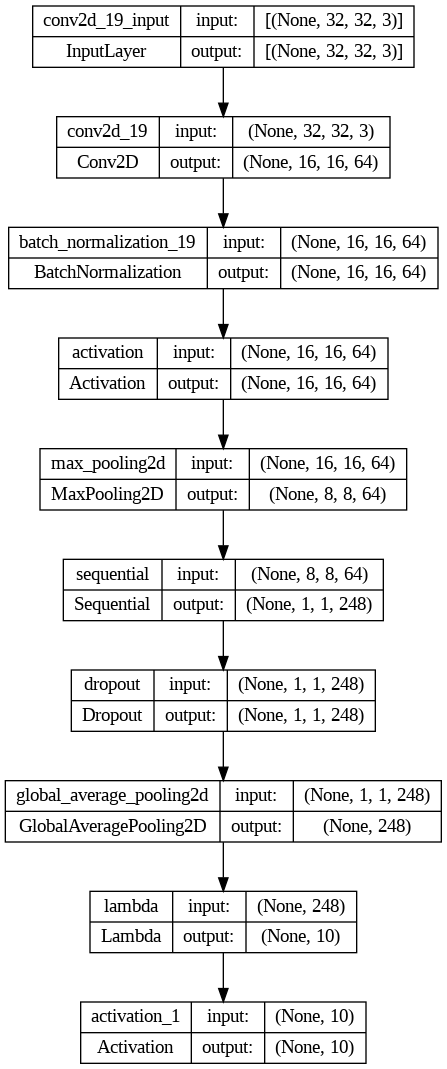

In [ ]:
tf.keras.utils.plot_model(densenet18, show_shapes=True)

# **Training**

# Load the data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalizng the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Splits the data into 70% training set and 30% testing set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# Flattens the label vectors
y_train, y_test, y_val = y_train.flatten(), y_test.flatten(), y_val.flatten()


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


def process_images(image, label):
    return image, label


train_dataset = (train_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

validation_dataset =(validation_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

test_dataset = (test_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Sets Adam optimizer to 1e-4
optimizer=tf.optimizers.Adam(learning_rate=1e-4)
densenet18.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


history = densenet18.fit(train_dataset,
            epochs=50,
            validation_data=validation_dataset)

Epoch 1/50
1093/1093 [==============================] - 29s 17ms/step - loss: 0.8916 - accuracy: 0.5877 - val_loss: 1.5570 - val_accuracy: 0.6502
Epoch 2/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.9055 - accuracy: 0.5825 - val_loss: 1.4861 - val_accuracy: 0.6645
Epoch 3/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.8828 - accuracy: 0.5930 - val_loss: 1.6574 - val_accuracy: 0.6360
Epoch 4/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.8937 - accuracy: 0.5869 - val_loss: 1.4074 - val_accuracy: 0.6718
Epoch 5/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.8785 - accuracy: 0.5925 - val_loss: 1.6203 - val_accuracy: 0.6502
Epoch 6/50
1093/1093 [==============================] - 18s 16ms/step - loss: 0.8893 - accuracy: 0.5879 - val_loss: 1.5283 - val_accuracy: 0.6537
Epoch 7/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.8857 - accuracy: 0.5882 - val_loss: 1.5147 -

# Visualize the training and validation accuracy

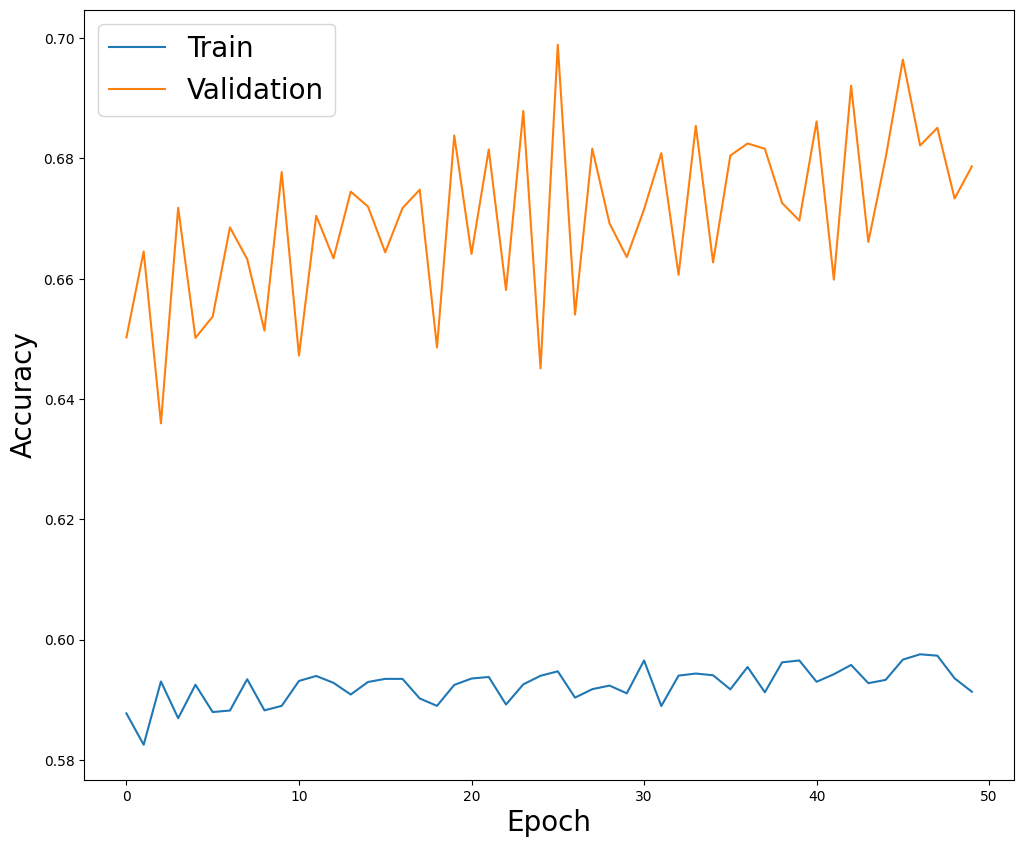

In [ ]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Validation Accuracy')
    plt.legend(["Train", "Validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

# Evaluate the trained model

In [ ]:
metrics = densenet18.evaluate(test_dataset, verbose=0)
print("Test loss:", metrics[0])
print("Test accuracy:", metrics[1])


Test loss: 1.727972149848938
Test accuracy: 0.6732772588729858


# Predict using the trained model

1/1 [==============================] - 0s 22ms/step


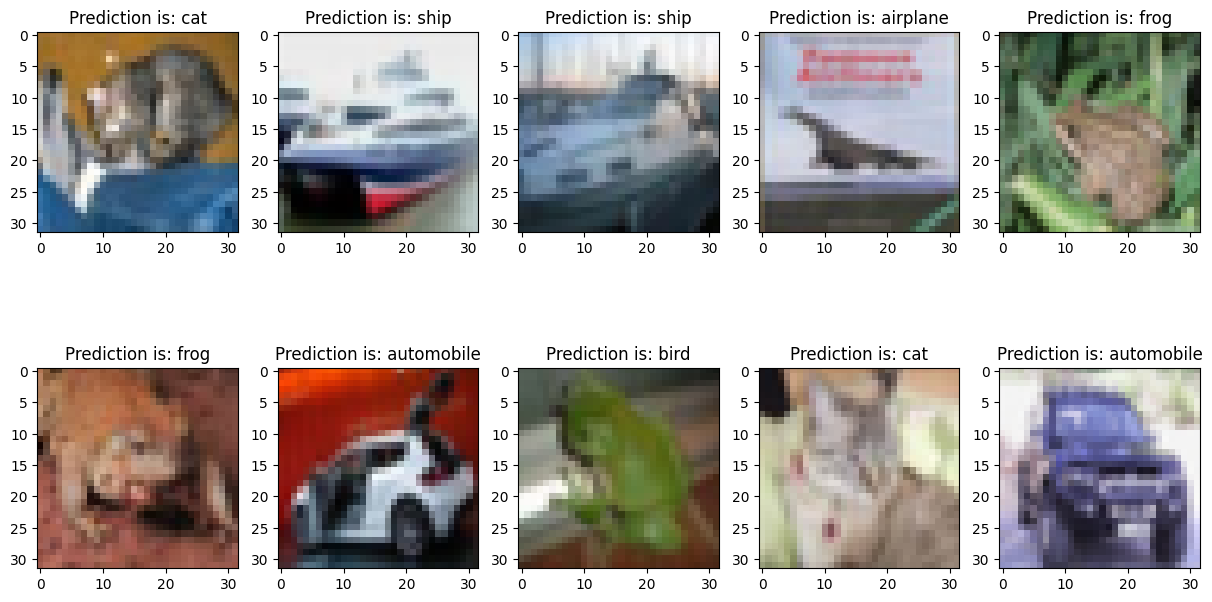

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

# Predicts the last 10 images
for i, (image, label) in enumerate(test_dataset.take(1)):
    for i in range(10):
      ax[i].imshow(image[i])
      ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[densenet18.predict(np.reshape(image[i], (1,32,32,3))).argmax()]), fontsize=12)